<a href="https://colab.research.google.com/github/pedrosena138/IF969-algorithms-and-data-structures/blob/master/ASSIN2_Portuguese_BERT_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
!pip install datasets transformers evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [77]:
import tensorflow as tf
from tensorflow import keras
from transformers.keras_callbacks import KerasMetricCallback

from datasets import load_dataset
from transformers import TFAutoModel, TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, create_optimizer, pipeline
from evaluate import load

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [64]:
# Plot style
mpl.rcParams['figure.figsize'] = (14, 12)
plt.style.use('seaborn')

BATCH_SIZE = 16
NUM_EPOCHS = 15
TASK =  'sts' # rte
MODELS = {
    "base": "neuralmind/bert-base-portuguese-cased",
    "large": "neuralmind/bert-large-portuguese-cased",
    "multi": "bert-base-multilingual-cased"
}

In [5]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)

Num GPUs Available:  1


In [6]:
def check_task(task):
    if not task:
        raise Exception('Task not informed')
    if task not in ('sts', 'rte'):
        raise Exception("Invalid task value. Choose 'sts' or 'rte'")
    return

def check_model(model_name):
    if not model_name:
        raise Exception('Model name not informed')
    if model_name not in MODELS.values():
        raise Exception("Invalid model name. Please check options in MODELS variable")
    return

# Base de Dados

## ASSIN 2

In [7]:
dataset = load_dataset('assin2')
dataset['train'][0]

Generating train split:   0%|          | 0/6500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2448 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset assin2 downloaded and prepared to /root/.cache/huggingface/datasets/assin2/default/1.0.0/8467f7acbda82f62ab960ca869dc1e96350e0e103a1ef7eaa43bbee530b80061. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'sentence_pair_id': 1,
 'premise': 'Uma criança risonha está segurando uma pistola de água e sendo espirrada com água',
 'hypothesis': 'Uma criança está segurando uma pistola de água',
 'relatedness_score': 4.5,
 'entailment_judgment': 1}

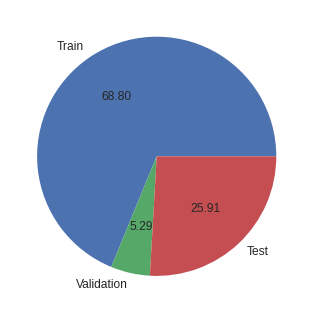

In [51]:
train_examples = dataset['train'].num_rows
val_examples = dataset['validation'].num_rows
test_examples = dataset['test'].num_rows

plt.pie([train_examples, val_examples, test_examples], labels=['Train', 'Validation', 'Test'], autopct='%.2f', textprops={'size': 'large'})
plt.show()

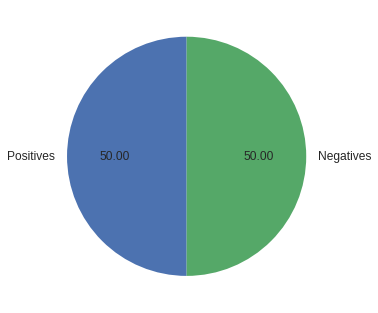

In [31]:
def count_pos_and_neg():
    pos = 0,
    neg = 0
    for key in dataset.keys():
        partial_neg, partial_pos = np.bincount(dataset[key]['entailment_judgment'])
        pos += partial_pos
        neg += int(partial_neg)

    return int(pos), neg

pos, neg = count_pos_and_neg()
plt.pie([pos, neg], labels=['Positives', 'Negatives'], autopct='%.2f', textprops={'size': 'large'}, startangle=90)
plt.show()

# Pre-processamento

In [143]:
def rename_encodings_keys(encodings, type):
    encodings[f'{type}_input_ids'] = encodings['input_ids']
    del encodings['input_ids']

    encodings[f'{type}_token_type_ids'] = encodings['token_type_ids']
    del encodings['token_type_ids']

    encodings[f'{type}_attention_mask'] = encodings['attention_mask']
    del encodings['attention_mask']

    return encodings

def get_related_scores():
    scores = []
    for key in dataset.keys():
        scores.extend(dataset[key]['relatedness_score'])
    return np.array(scores)

def encoder(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, padding="max_length", return_tensors='tf')

def normalize_relatedness_score(examples):
    scores = np.array(dataset['train']['relatedness_score'])
    return {'y': scaler.transform(scores.reshape(-1, 1)).reshape(1, -1)[0] }

def preprocess():
    encoded_dataset = dataset.map(encoder, batched=True)
    if TASK == 'sts':
        encoded_dataset = encoded_dataset.map(normalize_relatedness_score, batched=True)
    else:
        encoded_dataset = encoded_dataset.map(lambda x: {'label': x['entailment_judgment']} )
    X_train = model.prepare_tf_dataset(
        encoded_dataset["train"],
        shuffle=False,
        batch_size=BATCH_SIZE,
        collate_fn=data_collator,
    )

    X_val = model.prepare_tf_dataset(
        encoded_dataset["validation"],
        shuffle=False,
        batch_size=BATCH_SIZE,
        collate_fn=data_collator,
    )
        
    return X_train, X_val

def load_model(model_name):

    from_pt = True if model_name == MODELS["large"] else False

    if TASK == 'sts':
        model = TFAutoModel.from_pretrained(model_name, from_pt=from_pt)
        
        model.compile(
                optimizer='adam',
                loss='mse',
                metrics=[load('pearsonr')]
        )
        
        return model

    elif TASK == 'rte':        
        id2label = {0: "None", 1: "Entails"}
        label2id = {"None": 0, "Entails": 1}
        
        model =TFAutoModelForSequenceClassification.from_pretrained(model_name,
                                          num_labels=2,
                                          id2label=id2label, 
                                          label2id=label2id,
                                          from_pt=from_pt)
        
        model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=[load('f1')]
        )
        
        return model

In [144]:
X_train, X_val = preprocess()

  0%|          | 0/7 [00:00<?, ?ba/s]

ArrowInvalid: ignored

In [132]:
model_name = 'base'
tokenizer = AutoTokenizer.from_pretrained(MODELS[model_name], model_max_length=train_examples)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

if TASK == 'sts':
    scaler = MinMaxScaler()
    scores = get_related_scores()
    scaler.fit(scores.reshape(-1, 1))

# Hyper parameters
batches_per_epoch = train_examples // BATCH_SIZE
total_train_steps = int(batches_per_epoch * NUM_EPOCHS)

model = load_model(MODELS[model_name], TASK, total_train_steps)

Some layers from the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the

In [136]:
y_val

array([-0.03125   , -0.03125   , -0.01875001, ..., -0.08750001,
       -0.25      , -0.125     ])

# Fine-tuning

In [139]:
history = model.fit(x=X_train, validation_data=(X_val, y_val), epochs=3)

Epoch 1/3


ValueError: ignored

In [ ]:
class Metric:
    def __init__(self, name, balanced=False):
        self.metric_name = name
        self.func = load(self.metric_name)
        self.balanced = balanced

    def callback(self, eval_dataset):
        return KerasMetricCallback(metric_fn=self.compute, eval_dataset=eval_dataset)
        
    def compute(self, eval_predictions):
        predictions, labels = eval_predictions

        if self.balanced:
            predictions = np.argmax(predictions, axis=1)
        else:   
            predictions = predictions[:, 0]

        compute_func = self.func.compute(predictions=predictions, references=labels)


        if self.metric_name in ('precision', 'recall'):
            compute_func = self.func.compute(predictions=predictions, references=labels, zero_division=0)
          
        return compute_func

In [ ]:
def get_tf_dataset(dataset, tokenizer):
    texts_list = dataset['text'].values.tolist()
    labels_list = dataset['label'].values.tolist()
    
    encodings = tokenizer(texts_list, truncation=True, padding='longest')

    tf_dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels_list
    ))

    return tf_dataset

def get_model(model_name, num_labels=2):
    id2label = {0: "Negative", 1: "Positive"}
    label2id = {val: key for key, val in id2label.items()}

    optimizer = keras.optimizers.Adam(learning_rate=1e-6)
    # metricas: precisao e recall (precisao + recall = f_mesure)

    # metrics = [
    #     keras.metrics.Precision(name='precision'),
    #     keras.metrics.Recall(name='recall'),
    # ]

    from_pt = False if model_name == "bert-base-multilingual-cased" else True

    model = TFAutoModelForSequenceClassification.from_pretrained(model_name,
                                                             num_labels=2,
                                                             id2label=id2label, 
                                                             label2id=label2id,
                                                             from_pt=from_pt)
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics='accuracy')
    
    return model

In [ ]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss', fontsize=16)
  plt.legend()

def plot_metrics(history, metrics):
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend();

def plot_confusion_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
model_checkpoint = "BERTimbau-base"

models = {
    "BERTimbau-base": "neuralmind/bert-base-portuguese-cased",
    "BERTimbau-large": "neuralmind/bert-large-portuguese-cased",
    "mBERT": "bert-base-multilingual-cased"
}

model_name = models[model_checkpoint]

train_dataset, test_dataset = train_test_split(dataset, test_size=.1, shuffle=True)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=.2, shuffle=True)

tokenizer = BertTokenizer.from_pretrained(model_name, model_max_length=train_dataset.shape[0])

tf_train_dataset = get_tf_dataset(train_dataset, tokenizer)
tf_val_dataset = get_tf_dataset(val_dataset, tokenizer)
tf_test_dataset = get_tf_dataset(test_dataset, tokenizer)

model = get_model(model_name)
model.summary()

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108923136 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,924,674
Trainable params: 108,924,674
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(tf_train_dataset.batch(20),
                    epochs=20,
                    batch_size=2048,
                    validation_data=tf_val_dataset.batch(20))

Epoch 1/20
50/50 [==============================] - 81s 1s/step - loss: 6.0191 - accuracy: 0.3240 - val_loss: 5.4435 - val_accuracy: 0.3108
Epoch 2/20
50/50 [==============================] - 62s 1s/step - loss: 4.8984 - accuracy: 0.3470 - val_loss: 4.2013 - val_accuracy: 0.3147
Epoch 3/20
50/50 [==============================] - 63s 1s/step - loss: 3.8488 - accuracy: 0.3420 - val_loss: 2.9999 - val_accuracy: 0.2948
Epoch 4/20
50/50 [==============================] - 62s 1s/step - loss: 2.8632 - accuracy: 0.3110 - val_loss: 2.2415 - val_accuracy: 0.2988
Epoch 5/20
50/50 [==============================] - 63s 1s/step - loss: 2.4494 - accuracy: 0.3340 - val_loss: 1.9039 - val_accuracy: 0.2988
Epoch 6/20
50/50 [==============================] - 62s 1s/step - loss: 2.0712 - accuracy: 0.3810 - val_loss: 1.6890 - val_accuracy: 0.2988
Epoch 7/20
50/50 [==============================] - 62s 1s/step - loss: 1.8616 - accuracy: 0.3650 - val_loss: 1.5328 - val_accuracy: 0.2988
Epoch 8/20
50/50 [==

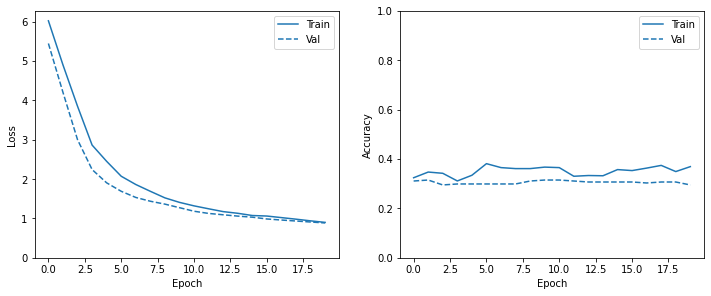

In [ ]:
plot_metrics(history, metrics=model.metrics_names)

In [ ]:
results = model.evaluate(tf_test_dataset.batch(20), batch_size=2048, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.8500600457191467
accuracy :  0.26618704199790955



Legitimate Transactions Detected (True Negatives):  11
Legitimate Transactions Incorrectly Detected (False Positives):  5
Fraudulent Transactions Missed (False Negatives):  97
Fraudulent Transactions Detected (True Positives):  26
Total Fraudulent Transactions:  123


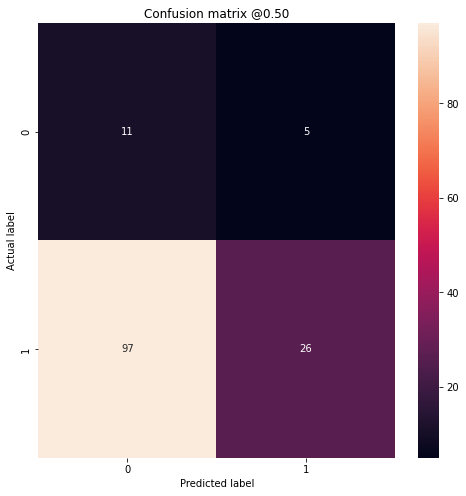

In [ ]:
test_sentences = test_dataset['text'].values.tolist()
encodings = tokenizer(test_sentences, truncation=True, padding='longest', return_tensors="np")
outputs = model(encodings).logits

y = test_dataset['label'].values.tolist()
y_hat = np.argmax(outputs, axis=1)

plot_confusion_matrix(y, y_hat)